In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from scipy import signal
from scipy.integrate import trapz
from scipy.interpolate import interp1d
import seaborn as sns
import array as arr

In [2]:
import neurokit2 as nk

# Time Domain analysis

In [3]:
def timedomain(rr):
    results = {}

    hr = 60000/rr
    
    results['Mean RR (ms)'] = np.mean(rr)
    results['STD RR/SDNN (ms)'] = np.std(rr)
    results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
    results['NNxx'] = np.sum(np.abs(np.diff(rr)) > 50)*1
    results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    return results

# Frequency Domain analysis

In [4]:
def frequency_domain(rri, fs=4):
    # Estimate the spectral density using Welch's method
    fxx, pxx = signal.welch(x=rr_interpolated_ecg, fs=fs)
    
    '''
    Segement found frequencies in the bands 
     - Very Low Frequency (VLF): 0-0.04Hz 
     - Low Frequency (LF): 0.04-0.15Hz 
     - High Frequency (HF): 0.15-0.4Hz
    '''
    cond_vlf = (fxx >= 0) & (fxx < 0.04)
    cond_lf = (fxx >= 0.04) & (fxx < 0.15)
    cond_hf = (fxx >= 0.15) & (fxx < 0.4)
    
    # calculate power in each band by integrating the spectral density 
    vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
    lf = trapz(pxx[cond_lf], fxx[cond_lf])
    hf = trapz(pxx[cond_hf], fxx[cond_hf])
    
    # sum these up to get total power
    total_power = vlf + lf + hf

    # find which frequency has the most power in each band
    peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
    peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
    peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

    # fraction of lf and hf
    lf_nu = 100 * lf / (lf + hf)
    hf_nu = 100 * hf / (lf + hf)
    
    results = {}
    results['Power VLF (ms2)'] = vlf
    results['Power LF (ms2)'] = lf
    results['Power HF (ms2)'] = hf   
    results['Power Total (ms2)'] = total_power

    results['LF/HF'] = (lf/hf)
    results['Peak VLF (Hz)'] = peak_vlf
    results['Peak LF (Hz)'] = peak_lf
    results['Peak HF (Hz)'] = peak_hf

    results['Fraction LF (nu)'] = lf_nu
    results['Fraction HF (nu)'] = hf_nu
    return results, fxx, pxx

In [5]:
ecg_data='-1376253,-1245184,-1376253,-1376254,-1310720,-1310717,-1245181,-1179648,-1245183,-1310717,-1376253,-1310719,-1441789,-1441789,-1310717,-1572862,-65535,851969,524288,-983039,-1441789,-1703934,-1703934,-1769470,-1835007,-1900542,-2031614,-2031616,-2097149,-2031614,-1900544,-1835005,-1638398,-1572862,-1441792,-1441790,-1310718,-1310719,-1310720,-1376254,-1376256,-1441790,-1441792,-1507328,-1441789,-1441790,-1376256,-1376254,-1376256,-1245184,-1376256,-1310720,-1310717,-1179647,-1376253,-1376255,-1376254,-1376253,-1376256,-1376253,-1441792,-1310718,655360,983041,-196608,-1310717,-1572861,-1703933,-1638397,-1507328,-1572864,-1572864,-1638398,-1638400,-1703934,-1507326,-1310718,-655359,-524288,-458752,-458752,-524286,-393216,-458750,-458749,-327680,-262141,-131070,0,2,2,2,131073,196608,-65533,65536,-65533,-65535,-131069,3,-393214,-327677,1507328,1966080,524289,65537,-393216,-655359,-655359,-720894,-786431,-851966,-851967,-983040,-983039,-786430,-720894,-589821,-458750,-327679,-327677,-262144,-196608,-262141,-327679,-327679,-327680,-458751,-589823,-589822,-655360,-720893,-589824,-655357,-655357,-655357,-720894,-851966,-851965,-851966,-917503,-917503,-851968,-1048574,-1048575,720898,1179648,131073,-1114109,-1441789,-1441792,-1507328,-1638399,-1703933,-1703934,-1835008,-1900544,-1900542,-1835006,-1703935,-1507328,-1245181,-1245183,-1310718,-1245184,-1179648,-1245183,-1441792,-1441790,-1310718,-1310717,-1310720,-1245184,-1245184,-1310718,-1245182,-1245182,-1310718,-1245184,-1310719,-1376255,-1376254,-1245184,-1572861,262145,1048578,393218,-917504,-1245183,-1441789,-1507326,-1376255,-1441790,-1441792,-1441790,-1376256,-1441791,-1376255,-1179647,-983038,-851968,-720893,-589823,-589823,-524288,-524287,-589822,-589823,-589823,-589822,-655357,-589822,-655360,-720894,-589824,-720893,-655358,-524288,-589821,-655360,-720894,-720893,-720893,-720896,-655360,-851967,-655358,327683,1638403,262145,-917503,-1114111,-1245181,-1376253,-1441791,-1441791,-1507328,-1572864,-1638397,-1638397,-1572861,-1441790,-1310719,-1048576,-1048575,-1048576,-1114111,-1179648,-1179645,-1245181,-1245183,-1245182,-1310718,-1310717,-1179648,-1310719,-1179647,-1245181,-1310720,-1376254,-1441789,-1441789,-1376254,-1245184,-1507325,-983039,65538,1048578,-458751,-1507327,-1572863,-1769470,-1769470,-1835006,-1835006,-1900541,-2031613,-2031613,-1966079,-1900541,-1769470,-1703935,-1572864,-1441791,-1441792,-1441791,-1376254,-1310719,-1376256,-1376256,-1310720,-1507327,-1507325,-1441792,-1507325,-1507325,-1441791,-1507327,-1507328,-1376255,-1441792,-1572862,-1572862,-1572863,-1572863,-1572864,-1441789,-1900542,-1900541,131073,655360,-983038,-1441791,-1835006,-1966078,-1966078,-1966080,-2031615,-2097149,-2097152,-2097150,-2097149,-2031614,-1966077,-1769472,-1376255,-1376255,-1376255,-1310720,-1376254,-1441789,-1376253,-1310719,-1376255,-1310720,-1245184,-1245183,-1245182,-1245182,-1310719,-1376255,-1376256,-1376256,-1441789,-1376254,-1507327,-1179646,-65534,1048576,-589824,-1179648,-1638399,-1638400,-1703934,-1703934,-1703933,-1769470,-1835006,-1900541,-1835006,-1769469,-1507326,-1376254,-1245182,-1114112,-1048575,-851968,-917502,-851968,-851966,-851966,-917502,-851968,-851968,-851968,-851965,-851968,-851967,-786430,-720894,-786431,-851968,-983039,-917503,-917504,-917504,-917502,-1114111,-589822,589827,1441795,-262141,-983039,-1114111,-1310718,-1310718,-1310720,-1310719,-1376255,-1441791,-1507327,-1441790,-1310717,-1179648,-1114112,-720895,-720894,-720893,-655360,-655359,-589823,-655357,-720894,-720893,-589822,-589822,-655357,-589823,-589823,-589823,-589824,-720893,-720895,-720893,-655357,-655357,-917502,-131072,1900544,917507,-589824,-917502,-983040,-1114110,-1114112,-1179647,-1179648,-1310717,-1310717,-1376253,-1310718,-1245182,-1179648,-983040,-851965,-720894,-720894,-655360,-720894,-720893,-655359,-655358,-720893,-720895,-720893,-720894,-720896,-720895,-720896,-655357,-524287,-589824,-786430,-786429,-851965,-917502,-851968,-655360,-1048574,-917504,1048576,1441792,-262143,-786431,-1114112,-1245184,-1310719,-1310719,-1310719,-1507325,-1572862,-1572864,-1572861,-1441792,-1441789,-1310718,-1048573,-983039,-1048573,-1048576,-1048573,-1179648,-1245183,-1310718,-1245184,-1245184,-1179646,-1179648,-1179645,-1114109,-1179647,-1310719,-1245184,-1245184,-1376255,-1376255,-1376253,-1572862,-917502,983041,327681,-524286,-1441792,-1638398,-1703933,-1703933,-1769471,-1835006,-1900543,-1835008,-1900542,-1966078,-1835006,-1703936,-1638398,-1441791,-1441789,-1310719,-1245184,-1310719,-1310718,-1376255,-1310719,-1376254,-1376255,-1245184,-1310718,-1245181,-1245182,-1310717,-1310718,-1245182,-1179648,-1310720,-1310719,-1310719,-1310720,-1376253,-1179647,-1638399,-1114111,983041,524288,-983040,-1376254,-1572864,-1769471,-1703935,-1703933,-1703935,-1769469,-1769471,-1835006,-1769470,-1769469,-1638400,-1114110,-1114109,-1114112,-1114111,-1179647,-1245181,-1179648,-1179645,-1114111,-1114109,-1114111,-1048573,-917504,-1048574,-1114110,-1179645,-1179645,-1114112,-1179646,-1048573,-1507326,-327680,1048577,1310723,-655360,-1310720,-1376256,-1507327,-1572861,-1572861,-1572862,-1638398,-1638398,-1703934,-1638399,-1572861,-1441792,-1376254,-1245181,-1114109,-1048574,-1048573,-1048573,-1048573,-983040,-1048573,-1048575,-1048574,-983038,-1114110,-983038,-1048574,-983038,-917504,-851968,-917503,-1048575,-1048575,-983038,-1048574,-917502,-1114111,-524287,1572866,1441795,-327677,-1114111,-1376255,-1441791,-1441789,-1376254,-1441791,-1441792,-1441791,-1507327,-1441789,-1376254,-720896,-655357,-589824,-720895,-720893,-655358,-720893,-655357,-720895,-655360,-655357,-655359,-720893,-589824,-655357,-720895,-786430,-786430,-720894,-720893,-589824,-983039,-851965,1245184,1572864,-196607,-720894,-1048574,-1245182,-1179648,-1179647,-1245184,-1310719,-1310720,-1507328,-1507327,-1441789,-1310718,-1179647,-1114111,-983038,-917504,-917501,-851965,-851965,-851965,-851966,-851966,-851968,-851967,-917501,-851966,-786431,-851965,-720894,-720894,-720896,-786432,-917502,-983037,-917503,-851966,-1048574,-917502,65538,1507329,196611,-1048574,-1310719,-1441792,-1507325,-1638397,-1638398,-1638398,-1703936,-1835005,-1835007,-1769469,-1638399,-1572863,-1376254,-1310718,-1310718,-1376254,-1376253,-1376256,-1376253,-1376255,-1245184,-1310720,-1376254,-1310717,-1310717,-1310719,-1376253,-1376256,-1376256,-1376254,-1310718,-1572862,-1310718,786434,589825,-262143,-1507325,-1638398,-1703935,-1703936,-1835007,-1900541,-1900542,-1966080,-1966079,-1900543,-1900541,-1703934,-1441792,-1310718,-1245184,-1245181,-1114111,-1048576,-1048576,-1114109,-1048576,-1048575,-983039,-1048574,-917502,-851968,-851965,-720894,-589824,-655358,-720893,-720894,-720894,-655359,-655357,-655357,-917502,-131070,1835011,917507,-458749,-786430,-983037,-983037,-917502,-983037,-983039,-1048576,-1245181,-1179648,-1048573,-983038,-917502,-458752,-524286,-524286,-589821,-524287,-458752,-524285,-524285,-458749,-524285,-524285,-458751,-393215,-458750,-524288,-589823,-589822,-655360,-655360,-589822,-917502,851968,1769474,1048577,-458749,-983040,-1048573,-1179647,-1179646,-1310717,-1310719,-1441789,-1507325,-1441792,-1441792,-1310719,-1179648,-1048575,-983040,-917504,-851968,-851968,-917502,-917501,-983037,-983038,-917504,-983037,-1048573,-1048573,-983037,-983040,-983039,-917503,-917504,-1048573,-1114109,-1179647,-1245181,-1245182,-1179647,-1507326,-1376254,393216,917506,196611,-1179648,-1638400,-1769472,-1769472,-1835007,-1900544,-1966079,-2031613,-2097150,-2097150,-2031616,-2031615,-1572861,-1638400,-1703934,-1703933,-1703933,-1703935,-1769470,-1703935,-1703933,-1638399,-1638399,-1572863,-1572863,-1572862,-1376254,-1441789,-1507326,-1441792,-1507326,-1441792,-1507325,-1507326,-1769470,-1048575,917507,196608,-655360,-1507327,-1638399,-1703933,-1572864,-1703934,-1638397,-1638399,-1703933,-1703935,-1507327,-1441789,-1376253,-1179648,-1048573,-983038,-786430,-720895,-720895,-720895,-786431,-851966,-917502,-917503,-1048574,-1114112,-1114112,-1114112,-1179646,-1179646,-1179648,-1114110,-1114111,-1114112,-1179648,-1245183,-1245184,-1310717,-1245184,-1441791,-524285,1179648,851970,-786430,-1507327,-1507328,-1638397,-1572863,-1572864,-1638398,-1769469,-1900541,-1769472,-1835006,-1769470,-1572864,-1245182,-1245181,-1245181,-1245183,-1245183,-1310719,-1310719,-1179645,-1245181,-1245182,-1114112,-1114112,-1179646,-1245181,-1114111,-1179647,-1179646,-1114112,-1179646,-1114110,-1114112,-1114109,-1441789,-589824,1114113,1048576,-393214,-1310719,-1376256,-1441791,-1507327,-1572861,-1507326,-1507327,-1572862,-1572862,-1441792,-1376253,-1245184,-983040,-917504,-917501,-786429,-720895,-720893,-655360,-720893,-720894,-851966,-720896,-720893,-786429,-720895,-720896,-655357,-655357,-786430,-786429,-720893,-786429,-720896,-851966,-917502,-851966,-983037,-917504,-1114112,-589824,1310723,786435,-720894,-1048576,-1310720,-1441791,-1376254,-1441791,-1441792,-1441792,-1507327,-1507328,-1376255,-1310718,-1245181,-1048573,-655357,-589822,-655359,-655357,-655360,-720895,-655359,-524288,-589823,-589824,-524286,-458750,-458750,-393214,-393213,-458751,-458752,-458752,-524286,-524286,-524286,-524286,-851966,851970,1966082,1245185,-327678,-851966,-983040,-983040,-983037,-1114109,-1114111,-1245182,-1310718,-1310718,-1310718,-1179648,-1048573,-851968,-786430,-589823,-720893,-655359,-655357,-589823,-655360,-720894,-720894,-786429,-851965,-786431,-720895,-720896,-720893,-655359,-720894,-720894,-720895,-655360,-720894,-851968,-851967,-917501,-917503,-851965,-1179648,-262142,917506,1245184,-524285,-917502,-1310717,-1376255,-1441791,-1507328,-1572861,-1572863,-1638400,-1638400,-1638397,-1507328,-1441790,-1310719,-851967,-917503,-983038,-1048574,-1114109,-1114110,-1114110,-1114111,-1179646,-1179645,-1114112,-1179647,-1114111,-1114110,-1114111,-983039,-1114110,-1114109,-1114109,-1179647,-1245181,-1245181,-983040,-1507327,-196608,917506,917506,-655360,-1441791,-1572862,-1638399,-1572862,-1638400,-1638399,-1703936,-1769470,-1835006,-1835008,-1703936,-1638397,-1441792,-1310719,-1245183,-1179647,-1179647,-1179648,-1245181,-1245181,-1245181,-1245184,-1310719,-1376253,-1245183,-1245184,-1310719,-1310718,-1310720,-1310718,-1310718,-1310719,-1310719,-1376254,-1441791,-1507326,-1507325,-1441790,-1441790,-1376255,-1769470,-786432,917505,720898,-786430,-1638397,-1835008,-1966077,-1900543,-2031613,-2031616,-2031616,-2162685,-2162688,-2162686,-1966079,-1441790,-1376256,-1441790,-1441790,-1507325,-1507325,-1507328,-1507328,-1507326,-1507327,-1507326,-1507325,-1441791,-1507326,-1376254,-1310719,-1310720,-1245181,-1507325,-1441792,-1507325,-1441791,-1441792,-1376254,-1769470,-1703934,393218,720899,-917504,-1441790,-1769470,-1900543,-1835007,-1900542,-1966077,-2031613,-2031614,-2031614,-1966080,-1835005,-1703935,-1703934,-1638397,-1441792,-1376254,-1376253,-1310717,-1310719,-1441789,-1376254,-1507325,-1441792,-1376256,-1376254,-1441789,-1441789,-1245184,-1310718,-1376253,-1310718,-1245183,-1310720,-1441790,-1376255,-1507327,-1507327,-1376254,-1376253,-1835005,-65536,917505,65537,-1310717,-1769471,-1900544,-1900542,-1900543,-1769472,-1835005,-1900542,-1835008,-1900543,-1966077,-1835005,-1638397,-1114111,-1114112,-1114109,-983040,-1048574,-1048574,-983039,-983039,-983040,-917503,-917503,-851968,-851966,-786429,-655358,-720896,-851966,-786432,-786431,-851967,-720896,-589824,-1048576,262145,1769472,1179650,-327677,-786432,-851966,-851968,-917501,-851966,-917501,-1048574,-1048576,-1048574,-983040,-851967,-720893,-524286,-458749,-262142,-131072,-65536,-131070,-131070,-131070,-131071,-131070,-131070,-131069,-131069,-131070,-65533,2,2,65539,65538,65537,65537,0,-65534,-65536,-196606,-131069,-131072,-131069,-393215,65539,2359296,1507328,524290,-262141,-458752,-655357,-589824,-655359,-720895,-851966,-851966,-851968,-851968,-786429,-720895,-589823,-327679,-327679,-327679,-393214,-458751,-458749,-458751,-524285,-524285,-458752,-524286,-458750,-458749,-458750,-458752,-524287,-589821,-655357,-720893,-720896,-589822,-983040,65536,1245184,1507330,-262143,-983038,-1048576,-1114112,-1310719,-1376256,-1376256,-1441789,-1572862,-1638398,-1507326,-1376254,-1310718,-1245182,-1048576,-917503,-917503,-917502,-851967,-851966,-851967,-851967,-917503,-851967,-851965,-851967,-917503,-851967,-851965,-851968,-786431,-720896,-917501,-851966,-851965,-983037,-917501,-917501,-786432,-1114110,2,1114112,1376258,-262144,-851968,-1310717,-1376255,-1376255,-1376255,-1441791,-1507328,-1638399,-1703933,-1572864,-1507328,-1441792,-1376253,-1048574,-1114109,-1114110,-1179645,-1179648,-1179648,-1245181,-1179646,-1245182,-1245182,-1245184,-1376253,-1245182,-1245181,-1376253,-1310720,-1441789,-1507325,-1572861,-1441790,-1572862,-1441790,-524286,983041,-327679,-1572862,-1769472,-1900541,-1900542,-1966077,-1966077,-2097150,-2162685,-2228223,-2293757,-2097151,-1900543,-1835006,-1703934,-1572861,-1441791,-1507325,-1310720,-1310720,-1376254,-1310720,-1376256,-1376256,-1376253,-1376253,-1376253,-1310718,-1245184,-1310718,-1179645,-1179648,-1310717,-1310718,-1310720,-1310720,-1376254,-1245184,-1376253,-1507325,-589823,1114113,-196607,-1376255,-1572862,-1638397,-1703933,-1769471,-1769470,-1769469,-1900542,-1900544,-1900542,-1835005,-1703934,-1638397,-1048574,-983040,-1048574,-1048574,-1048573,-983040,-983040,-983038,-917501,-917503,-917502,-786432,-786429,-786430,-786432,-851968,-851966,-851967,-917504,-851967,-1245182,393218,1376256,655360,-851968,-1376254,-1310720,-1310720,-1376255,-1376254,-1376254,-1572861,-1507328,-1507327,-1376255,-1245181,-1114110,-1048573,-917501,-786432,-786429,-720893,-720894,-655357,-589824,-720894,-720895,-720895,-720893,-720893,-720894,-655360,-720894,-655360,-589821,-720894,-720893,-720895,-786431,-655360,-655360,-655358,-1048573,-262144,1769474,1507331,-131072,-917501,-1048573,-1245182,-1245182,-1179648,-1245181,-1310720,-1376254,-1376255,-1376254,-1245181,-655358,-720894,-720893,-655360,-720893,-655357,-720893,-720895,-720893,-655359,-720895,-720893,-589823,-589824,-655359,-589822,-524287,-589824,-655359,-720894,-655360,-655359,-720895,-655357,-917502,-196606,1900544,851969,-458752,-786432,-917504,-1048575,-1114111,-1114112,-1179648,-1245183,-1310718,-1376254,-1245184,-1114110,-1048573,-917501,-786430,-720893,-589824,-524287,-655358,-589823,-589822,-720895,-720893,-655359,-655358,-720893,-655360,-655357,-720893,-655360,-589823,-589822,-655359,-589824,-589823,-720893,-655360,-720894,-786431,-786431,-851965,-720894,-1048575,-983039,983041,1507331,-131069,-655360,-1114111,-1245182,-1179648,-1245183,-1376255,-1441789,-1441791,-1507326,-1507326,-1441789,-1376254,-1179647,-851966,-786432,-851968,-917502,-917503,-917502,-917503,-917501,-851968,-983038,-983037,-851968,-851967,-917502,-983037,-851967,-851966,-851967,-917502,-917502,-983039,-983040,-1048573,-1048575,-983039,-1245183,-65534,1310722,917504,-655360,-1376254,-1572861,-1572863,-1638399,-1703934,-1703935,-1769470,-1835007,-1900542,-1900541,-1769469,-1638398,-1507327,-1441791,-1310719,-1310719,-1245183,-1245182,-1310720,-1376255,-1441790,-1441789,-1376254,-1376256,-1376256,-1310720,-1376254,-1376256,-1376254,-1310717,-1310720,-1376253,-1310717,-1376253,-1441792,-1441792,-1441792,-1441792,-1507326,-1310720,-1769471,-1638400,262146,589824,-983037,-1441789,-1703936,-1835005,-1835007,-1966079,-1966078,-2097150,-2097151,-2162685,-2031614,-1966077,-1966077,-1310718,-1310720,-1376256,-1376253,-1376254,-1310720,-1376253,-1441791,-1245183,-1245183,-1376253,-1310718,-1179648,-1179646,-1245183,-1245183,-1245181,-1245181,-1245182,-1310720,-1376254,-1310720,-1310720,-1310717,-1507328,-1703934,-65533,1114112,-458752,-983040,-1507327,-1638399,-1572864,-1638397,-1638397,-1769471,-1900544,-1900542,-1835008,-1769472,-1703933,-1441791,-1245184,-1179647,-1179645,-1114110,-1114110,-1048573,-983039,-983040,-1048574,-1114109,-1114109,-1114110,-1114109,-1114109,-1114109,-1048576,-1048573,-1048573,-1048573,-917504,-917503,-983037,-1048573,-1048573,-917502,-1048574,-1048573,-1048575,-1114112,-131070,1507331,3,-983040,-1179646,-1310720,-1376253,-1376254,-1310719,-1441791,-1507328,-1507328,-1572861,-1441792,-1376253,-1245182,-851965,-786431,-851966,-917501,-851968,-851968,-851967,-851967,-851967,-851967,-851967,-917502,-851967,-786429,-786430,-720896,-786429,-720896,-786431,-851965,-720893,-786431,-851966,-655359,-1048575,-65536,1048579,1376259,-262142,-983038,-1048573,-1114110,-1179647,-1179647,-1179646,-1245184,-1376255,-1376256,-1310720,-1245182,-1048576,-983040,-851967,-786430,-655359,-655358,-720893,-720893,-720894,-655359,-720895,-655360,-655360,-720894,-655360,-720893,-720893,-655357,-655358,-655357,-655357,-589822,-589822,-655359,-655360,-655360,-786431,-786429,-589822,-720895,-786431,1310723,1900545,524288,-655359,-983040,-1048573,-1179645,-1179648,-1179647,-1179647,-1310719,-1441789,-1310720,-1310719,-1179646,-1048574,-655360,-589823,-655360,-786430,-720893,-720893,-720896,-720894,-655360,-720894,-655359,-655359,-655358,-655357,-655358,-589823,-589822,-720893,-720895,-720894,-720894,-720894,-524287,-917504,-393215,1703937,1114115,262145,-720896,-1048575,-1114111,-1048576,-1114109,-1245181,-1310719,-1376254,-1441790,-1376253,-1245181,-1114111,-983038,-851966,-720895,-655358,-720894,-655358,-589824,-655358,-720896,-720895,-720894,-720895,-720895,-720895,-720896,-720894,-655358,-720893,-589823,-589822,-655360,-720896,-786430,-786429,-720896,-655360,-589823,-1048573,131073,1835010,1441794,-327678,-1048573,-1179646,-1179647,-1310718,-1376253,-1376253,-1441790,-1507326,-1441791,-1507326,-1376255,-1179646,-1114111,-720896,-786431,-720893,-786429,-786432,-851966,-786432,-786431,-786432,-720896,-720893,-786431,-851966,-655360,-917502,-851968,-786429,-917503,-917501,-983037,-786431,-1048575,-589822,1376259,1376257,-196606,-1179647,-1376254,-1441791,-1441791,-1507327,-1507328,-1638399,-1769469,-1835005,-1769471,-1638400,-1572862,-1376256,-1310718,-1114110,-1179645,-1114110,-1048575,-1114109,-1114109,-1179646,-1376254,-1310720,-1310717,-1310717,-1310719,-1245181,-1245184,-1245184,-1114111,-1245181,-1310718,-1376254,-1376255,-1441789,-1441789,-1376253,-1507325,-1507325,655360,1114114,-196607,-1441790,-1769470,-1835005,-1900542,-1966077,-1966078,-1966078,-2097149,-2097151,-2097149,-1966077,-1900541,-1638398,-1245184,-1310717,-1310719,-1376254,-1376255,-1310719,-1376253,-1376254,-1310720,-1245183,-1245182,-1245182,-1245181,-1245182,-1376253,-1376255,-1310717,-1376254,-1310720,-1245182,-1507327,-1310719,851969,1114115,-458752,-1376256,-1638398,-1703936,-1769469,-1900541,-1835006,-1835007,-1966080,-2031615,-1966077,-1835006,-1835006,-1638399,-1507325,-1376254,-1245184,-1179648,-1179646,-1179646,-1179648,-1245181,-1179648,-1245182,-1245182,-1310717,-1245181,-1179646,-1048575,-1048573,-983040,-1048575,-1179646,-1179647,-1245182,-1179648,-1179645,-1114109,-1441790,-589822,1441794,65539,-720895,-1376256,-1507325,-1507327,-1572864,-1638398,-1638398,-1638400,-1703936,-1703935,-1638399,-1572862,-1441791,-1310720,-851968,-917501,-917501,-917502,-851968,-983039,-983038,-917503,-917504,-917502,-917504,-786432,-720893,-720894,-917501,-917504,-851965,-851967,-917501,-720895,-1048574,-851966,1376257,917504,-65533,-917504,-1179647,-1310717,-1310718,-1376255,-1441790,-1441789,-1507326,-1507328,-1507327,-1441791,-1179645,-1048575,-983039,-851968,-786430,-720896,-655360,-720895,-720894,-720895,-786432,-786432,-720894,-720896,-720894,-655359,-655358,-589823,-589821,-524287,-589824,-655360,-655359,-655358,-655360,-720895,-720894,-983038,65539,1900544,589825,-131071,-851966,-1048575,-1114109,-1114112,-1179647,-1245182,-1245184,-1376254,-1441789,-1245182,-1179646,-655358,-589821,-655358,-720895,-655357,-786431,-786430,-655359,-720895,-655360,-655359,-720893,-589824,-589823,-524288,-524286,-655358,-655358,-655357,-720896,-786429,-720896,-655358,-917501,-262144,1703939,1703938,65536,-917503,-1179647,-1245182,-1245184,-1245183,-1376253,-1376253,-1507326,-1572861,-1441790,-1310719,-1310717,-1179647,-1048576,-983040,-851968,-851965,-786432,-851966,-851968,-786431,-786431,-851968,-851968,-851968,-786432,-786432,-851968,-851968,-786432,-786432,-786431,-851966,-983037,-983037,-983039,-1048576,-1048576,-851968,-1245182,131075,1114114,851968,-720895,-1310719,-1441789,-1507327,-1507327,-1638397,-1572864,-1703934,-1835008,-1900541,-1900541,-1769469,-1572862,-1507327,-1245181,-1245184,-1310718,-1376255,-1376255,-1310720,-1310719,-1310717,-1310719,-1310718,-1310718,-1376256,-1245182,-1179648,-1245181,-1376253,-1376255,-1310720,-1441789,-1376255,-1179648,-1638400,-1179645,851968,458755,-983038,-1376255,-1703934,-1769470,-1703934,-1703934,-1769469,-1835008,-2031614,-2031613,-1900541,-1835005,-1703936,-1572862,-1441791,-1310720,-1310717,-1245181,-1245184,-1245181,-1179647,-1310718,-1245184,-1310718,-1310717,-1245183,-1310717,-1245184,-1310718,-1245184,-1179645,-1245181,-1245184,-1310717,-1310718,-1376254,-1376254,-1179647,-1441792,-1179647,0,1114113,-458750,-1048573,-1507327,-1638398,-1638400,-1703933,-1703934,-1769471,-1900544,-1900544,-1900541,-1769472,-1638399,-1572863,-1114111,-1114111,-1114110,-1179645,-1179647,-1245181,-1245181,-1114112,-1179646,-1114112,-1179645,-1114112,-1048573,-1048574,-1114111,-1245182,-1310717,-1310717,-1310719,-1245182,-1310720,-1245184,-196606,1245184,-393214,-1376253,-1507328,-1441791,-1507325,-1572862,-1572862,-1507328,-1638399,-1703934,-1703935,-1572864,-1507325,-1441790,-1245184,-1114109,-851967,-786432,-720896,-851965,-851967,-786430,-851965,-786430,-720895,-786430,-786431,-655358,-655360,-786429,-589823,-655358,-720893,-720894,-786429,-851965,-786432,-786431,-589824,-1114110,-851967,1376258,1114113,196608,-786430,-1048576,-1179648,-1245181,-1179645,-1114111,-1310717,-1310720,-1376255,-1310719,-1245181,-1179646,-1048574,-720895,-720894,-655360,-720896,-786430,-786431,-720894,-720893,-720893,-655359,-589824,-589822,-655359,-589823,-655357,-786431,-786431,-720895,-720896,-786430,-655359,-720895,-1048574,786433,1572865,720898,-720896,-1114109,-1179646,-1179647,-1179647,-1179646,-1179647,-1245184,-1441791,-1376255,-1310718,-1179647,-1048575,-917503,-851966,-720895,-589824,-655358,-655359,-720893,-720894,-720893,-720895,-655359,-589824,-655358,-720893,-589824,-589822,-655358,-655359,-589821,-589823,-655360,-720895,-786430,-720894,-786429,-720894,-851966,-786430,1376259,1769475,393217,-720893,-983038,-1048574,-1048576,-1048576,-1114110,-1179647,-1245183,-1376255,-1376253,-1245181,-1179645,-983038,-589823,-589823,-589824,-655360,-720896,-720895,-655360,-655359,-655358,-720894,-720896,-720893,-655358,-720894,-720894,-589824,-655360,-720896,-655360,-720894,-786430,-786430,-655357,-786432,-720894,1310722,1179648,262146,-917502,-1114111,-1179648,-1179648,-1310720,-1376255,-1441790,-1507327,-1572864,-1507328,-1441792,-1310720,-1245181,-1048573,-983040,-851968,-786432,-851966,-851965,-851967,-917501,-851968,-851966,-851965,-786432,-851966,-851967,-851966,-720894,-720893,-720896,-655359,-655360,-851965,-851967,-786432,-851966,-851966,-851965,-851965,-983040,720898,1507331,720897,-720895,-1048574,-1245184,-1376254,-1310719,-1376255,-1507325,-1441791,-1638398,-1703933,-1572862,-1441792,-1310720,-917503,-917501,-851967,-983037,-1048574,-1048573,-1048573,-1048576,-1048573,-917504,-983040,-1048573,-983040,-983038,-917503,-917501,-1048574,-1048575,-1048574,-1048574,-983040,-983038,-1376253,-1376253,393219,1310720,-262141,-851965,-1245184,-1441789,-1507325,-1572861,-1572862,-1638397,-1769469,-1835005,-1703933,-1703933,-1638400,-1507325,-1310717,-1114112,-1048576,-1048575,-983040,-1048573,-1048574,-1114110,-1114111,-1114110,-1179647,-1114112,-1179645,-1179646,-1114112,-1179645,-1179647,-1114111,-1114110,-1179648,-1245184,-1310719,-1310717,-1376255,-1310717,-1507326,-1376256,786434,524289,-327677,-1310717,-1638400,-1769469,-1703934,-1703933,-1769469,-1769471,-1835008,-1900544,-1835007,-1835005,-1638399,-1114112,-1114109,-1114112,-1179645,-1179645,-1179647,-1245183,-1179648,-1179648,-1179645,-1048574,-1179645,-1048575,-1048573,-917504,-983039,-1048575,-1114109,-1114112,-1114111,-1048575,-983038,-1310719,458754,1376258,524289,-917504,-1376255,-1441790,-1376256,-1441790,-1441792,-1572863,-1638398,-1638399,-1638398,-1572863,-1441789,-1245184,-1179646,-1114109,-983040,-851968,-851967,-851966,-786431,-851965,-786432,-786430,-786429,-786431,-786430,-720896,-720895,-720895,-720895,-655359,-720894,-786429,-786430,-786430,-720895,-851965,-720893,-851966,-655358,1507329,1245184,262146,-851965,-1179645,-1179647,-1179645,-1245182,-1310719,-1441789,-1507327,-1507327,-1441790,-1376256,-1245181,-1114112,-720893,-720893,-786430,-851967,-851966,-786430,-851967,-917501,-917501,-851966,-851967,-917504,-917504,-720895,-851967,-917503,-917502,-1048573,-1048574,-1179645,-983039,-1114109,-1245181,720896,1245184,131073,-1179645,-1507325,-1507328,-1572864,-1638398,-1638397,-1703933,-1835005,-1900542,-1769472,-1703936,-1638400,-1507325,-1376256,-1376254,-1310719,-1245182,-1179648,-1245183,-1245182,-1245182,-1245181,-1245184,-1310719,-1245184,-1245183,-1245182,-1179646,-1179645,-1114109,-1048573,-983040,-1114112,-1114109,-1048576,-1179647,-1179646,-983040,-1048574,-1179645,917507,1507328,3,-1114110,-1376254,-1376255,-1376254,-1376255,-1441791,-1441792,-1507327,-1638398,-1638398,-1507325,-1310717,-1114111,-1048575,-655359,-720893,-720894,-720893,-720895,-720894,-655359,-720894,-655360,-655359,-655359,-655358,-655358,-720895,-786430,-786430,-851966,-786429,-720896,-720893,-1048574,393219,2097154,1441792,-458751,-983037,-1179646,-1245181,-1114112,-1245184,-1245184,-1376253,-1507325,-1441789,-1376256,-1310718,-1179645,-917504,-851968,-786429,-655359,-589822,-589822,-655359,-655360,-720893,-655359,-655360,-655360,-720893,-720896,-655360,-655360,-720893,-655358,-720894,-786429,-720895,-720895,-720896,-786429,-720894,-983040,-196606,1835010,589826,-262144,-983037,-983040,-1114110,-1048576,-1048575,-1114112,-1179645,-1245183,-1245183,-1179646,-1114111,-1048575,-524288,-589821,-524287,-589821,-655357,-589822,-589824,-720893,-655357,-655357,-655358,-655360,-655358,-655358,-589824,-655360,-720894,-720894,-720894,-720894,-524288,-720896,-655357,1441792,1310721,393217,-786431,-983038,-1114109,-1048576,-1114111,-1179646,-1179648,-1376253,-1507325,-1310720,-1245183,-1179647,-1048573,-917504,-917504,-851965,-786429,-720896,-720895,-655359,-720894,-720896,-720895,-720894,-720895,-720894,-720893,-786430,-786430,-720896,-655360,-786429,-851965,-851966,-851966,-786430,-786429,-851967,-1048575,0,1638402,393218,-393213,-1179648,-1310718,-1376253,-1376254,-1441790,-1507327,-1638400,-1769470,-1703933,-1638399,-1638398,-1507325,-1114110,-1114112,-1245182,-1310718,-1245184,-1310718,-1310720,-1245183,-1310718,-1310718,-1179647,-1310719,-1310720,-1245183,-1245181,-1310718,-1310720,-1376254,-1376255,-1376256,-1245184,-1638399,-1572863,327681,851969,65536,-1310720,-1638398,-1835006,-1835008,-1835005,-1835007,-1966079,-2031614,-2097149,-1966080,-1900544,-1835007,-1703936,-1572861,-1507325,-1441791,-1376256,-1310717,-1310717,-1376253,-1441790,-1376254,-1376253,-1376254,-1310719,-1245181,-1245182,-1245181,-1048575,-1048576,-1245182,-1179647,-1179647,-1179648,-1179645,-1245181,-1048574,-1441792,-983038,1245187,786432,-786432,-1114111,-1310717,-1310718,-1310717,-1310719,-1376256,-1376256,-1507326,-1507325,-1245184,-1245181,-1179648,-1048574,-720893,-655358,-655359,-720894,-655360,-655359,-655359,-720895,-655360,-655357,-589823,-589822,-589823,-655359,-720893,-720894,-720896,-655360,-720893,-720893,-720894,1376258,1900546,524290,-720893,-917503,-1048573,-983039,-1048575,-1048576,-1179645,-1310719,-1310719,-1310718,-1245182,-1114111,-1048573,-983039,-851965,-720893,-655357,-589823,-655360,-589824,-589823,-720894,-720896,-655360,-720895,-720894,-655359,-720896,-786431,-655359,-524288,-720895,-720896,-786429,-720895,-720894,-655357,-589823,-983037,786435,1703938,917505,-589822,-1114112,-1245182,-1245184,-1376253,-1310720,-1310720,-1507325,-1572862,-1572861,-1507328,-1310720,-1310718,-851967,-720896,-851965,-851965,-851965,-786432,-786432,-851965,-851966,-851967,-786431,-786430,-786431,-655357,-720895,-786431,-720894,-786430,-851967,-851968,-851967,-786432,-917501,983043,1638402,655360,-720894,-1245181,-1310720,-1245184,-1245184,-1376255,-1441790,-1441792,-1507327,-1507327,-1441790,-1376254,-1245181,-1114111,-983040,-983038,-983037,-983038,-851965,-851968,-983039,-917504,-851966,-851967,-917502,-851968,-786432,-851965,-851966,-851966,-786429,-851965,-851965,-851965,-851966,-851968,-917504,-917503,-851965,-1179646,-393215,720896,1441792,-131071,-1048574,-1179645,-1310718,-1441789,-1376256,-1441792,-1572862,-1572864,-1638397,-1638399,-1441790,-1310720,-1310719,-983040,-983038,-917504,-1048573,-1114110,-1048576,-1114109,-1114110,-1048574,-1114109,-1114111,-1048575,-917503,-917504,-983038,-1114109,-1179647,-1114112,-1114109,-1179647,-1114110,-1441792,-1441792,327683,1114112,-458751,-1048575,-1507326,-1507327,-1507325,-1507328,-1572862,-1638398,-1638400,-1835005,-1835007,-1638400,-1638397,-1572861,-1310720,-1245182,-1179646,-1114110,-1114112,-1114111,-1048576,-1114112,-1114110,-1048576,-1048574,-1048573,-1048574,-983040,-917502,-851968,-786430,-786431,-851967,-851967,-917501,-851968,-851967,-917504,-851966,-1114109,-393216,1572866,655360,-196607,-917503,-1048576,-1245182,-1245182,-1310717,-1376254,-1310719,-1376253,-1376256,-1310720,-1245184,-1114112,-655360,-589824,-655359,-720895,-720896,-655360,-589822,-720894,-655358,-655359,-655358,-655357,-589823,-589821,-589822,-720895,-720893,-655359,-655359,-720895,-655359,-786431,-983040,589824,1900544,1179648,-458752,-917504,-1245181,-1245181,-1179645,-1179648,-1310718,-1376256,-1376256,-1441790,-1245181,-1179647,-983040,-786430,-720896,-720893,-524286,-524285,-524287,-524286,-589823,-589824,-589824,-589823,-589823,-720893,-655360,-655359,-655358,-589823,-524287,-524287,-524288,-655359,-720894,-720893,-720894,-524287,-720895,-655360,1376259,1310720,393218,-786430,-983039,-1048575,-1048576,-1179645,-1179648,-1310717,-1310720,-1441790,-1441789,-1310718,-1245181,-1114110,-786431,-720895,-720893,-720893,-655359,-720894,-720896,-655360,-655360,-720895,-655357,-720893,-720895,-589824,-720895,-851965,-851965,-851968,-983039,-983038,-786431,-1048573,-655360,1310723,983040,131072,-1048576,-1310717,-1376253,-1310720,-1507327,-1507328,-1507328,-1572861,-1638400,-1572862,-1572861,-1441791,-1310720,-1179647,-1114112,-1114109,-1048573,-1048573,-1048574,-1114109,-1179646,-1179647,-1114112,-1179645,-1179646,-1114112,-1114110,-1179645,-1179648,-1245181,-1179646,-1114112,-1114111,-1179646,-1179647,-1179648,-1310719,-1245181,-1507325,-589823,1310720,262145,-589821,-1507327,-1703934,-1769470,-1769471,-1769472,-1835008,-1900544,-2031616,-1966079,-1900544,-1900542,-1769471,-1310719,-1310719,-1310719,-1376254,-1376254,-1376255,-1441792,-1376254,-1376256,-1376256,-1310719,-1310720,-1310717,-1310717,-1310719,-1310718,-1376253,-1441789,-1441791,-1441789,-1376254,-1638397,-917503,851970,65538,-720893,-1638399,-1769469,-1703936,-1769469,-1835008,-1900542,-1900542,-2031613,-2031615,-1966079,-1900543,-1769471,-1703933,-1572863,-1507325,-1376253,-1441789,-1310719,-1376253,-1376255,-1376253,-1376254,-1310719,-1376253,-1310717,-1245181,-1245184,-1179648,-1179646,-1179646,-1245183,-1179646,-1245183,-1245184,-1179647,-1179646,-1376253,-1572861,-131070,1245185,-196606,-851968,-1441792,-1507325,-1507325,-1507326,-1441792,-1507327,-1638399,-1703934,-1703934,-1507327,-1441790,-1310720,-851968,-851965,-851965,-786429,-851965,-851968,-786431,-786431,-720893,-655359,-720893,-655358,-655359,-720894,-720896,-655359,-720894,-720894,-786430,-655359,-1048573,-589823,1507331,1179648,-458749,-851966,-1114110,-1179646,-1179645,-1179645,-1310717,-1376255,-1376255,-1441791,-1441790,-1310717,-1179648,-1048576,-983037,-851966,-786430,-786429,-786429,-720896,-655360,-720895,-720896,-786429,-720896,-786431,-786429,-720894,-720894,-655360,-720894,-720894,-720895,-786429,-720894,-786429,-720893,-786429,-720896,196609,1900544,589826,-655360,-917504,-1179645,-1245182,-1179648,-1179647,-1310720,-1441791,-1507325,-1441792,-1376255,-1245184,-1179647,-720894,-720894,-655357,-655359,-720895,-786430,-786431,-786431,-851967,-786432,-851965,-851965,-786430,-786431,-786430,-851965,-851965,-851967,-917501,-917503,-851968,-1114109,-524288,524288,1376256,-196605,-1179647,-1310719,-1441791,-1441790,-1507325,-1507328,-1703934,-1769472,-1769471,-1703934,-1638399,-1507328,-1441791,-1245184,-1245181,-1114112,-1114109,-1179646,-1179646,-1179645,-1179648,-1245184,-1376253,-1376256,-1376254,-1376255,-1310720,-1179648,-1245184,-1179646,-1245182,-1376254,-1376255,-1376255,-1376254,-1376255,-1310720,-1310717,-1703933,-1048573,917506,196610,-1114112,-1507327,-1703934,-1769472,-1769471,-1769471,-1835008,-2031614,-2031615,-2031615,-1900544,-1835007,-1769471,-1638400,-1310718,-1310720,-1376254,-1310720,-1310720,-1245184,-1245184,-1376255,-1245183,-1179646,-1245183,-1245183,-1114110,-1179645,-1179647,-1245184,-1310717,-1245184,-1245184,-1245182,-1441792,-983037,196608,1179648,-458749,-983040,-1441790,-1572861,-1572862,-1572864,-1507328,-1703933,-1769469,-1703935,-1703934,-1572863,-1507325,-1310720,-1245182,-1179645,-1048576,-983040,-1048575,-1048576,-1114110,-1114112,-1114111,-1179645,-1179647,-1179646,-1245182,-1245181,-1245181,-1179647,-1179648,-1114112,-1114110,-1179648,-1245182,-1310718,-1376253,-1310720,-1179646,-1572861,-1572864,262146,1048579,-589822,-1179647,-1572864,-1638400,-1572864,-1572862,-1638397,-1703934,-1769470,-1835006,-1835005,-1769471,-1769469,-1507326,-1114111,-1048576,-1114109,-1114110,-1114111,-1114112,-1114111,-1179645,-1114111,-1114111,-1048576,-1048573,-1048574,-983040,-983040,-983039,-983038,-983037,-983039,-917504,-983039,-983037,-1048576,-983040,1179649,1572865,131072,-1048576,-1310720,-1441789,-1376256,-1376256,-1441791,-1507327,-1638400,-1703935,-1703936,-1572864,-1441791,-1245184,-1179648,-1179645,-983040,-983038,-917504,-983039,-983037,-917501,-917503,-917502,-851968,-851968,-851966,-851966,-917502,-851967,-851966,-851967,-851965,-851967,-851968,-917503,-983037,-917503,-917503,-786431,-1179645,-131069,1048578,1310723,-327680,-917501,-1245184,-1441791,-1376253,-1441789,-1441790,-1572862,-1703935,-1703934,-1703933,-1638398,-1507327,-1441790,-1114110,-1179647,-1179648,-1310718,-1310718,-1245184,-1310719,-1376253,-1310719,-1376253,-1310719,-1310720,-1376255,-1376256,-1310718,-1376254,-1441791,-1441790,-1441791,-1507325,-1507325,-1376256,-1441789,-1703933,131072,917504,262146,-1179647,-1769470,-1835005,-1835008,-1900541,-1900543,-1966079,-2097152,-2228222,-2097151,-2162685,-1966077,-1835007,-1769469,-1638398,-1507328,-1441789,-1376253,-1376254,-1310720,-1572861,-1507328,-1572861,-1507326,-1507328,-1572863,-1507328,-1441790,-1441790,-1441789,-1376253,-1310717,-1376253,-1310720,-1376253,-1376256,-1441789,-1376255,-1245182,-1441792,-1048574,65537,1179651,-262143,-1310717,-1441791,-1441792,-1507326,-1572861,-1507327,-1638397,-1769469,-1835007,-1769470,-1507326,-1441792,-1441792,-786431,-851965,-851967,-851967,-917503,-917502,-851966,-851966,-917502,-851967,-786429,-786432,-786431,-655358,-655359,-786429,-786430,-786430,-851965,-786431,-851967,-720894,-1114110,-655357,1441793,983041,131074,-983037,-1310717,-1310717,-1310717,-1441791,-1507325,-1638397,-1638400,-1572864,-1572864,-1441792,-1376254,-1048576,-983039,-917503,-917504,-786432,-786430,-786429,-786432,-851965,-851967,-786432,-851968,-851965,-786432,-786431,-851965,-917501,-917503,-851968,-786431,-786429,-851967,-851966,-851968,-851966,-917502,-851967,-917503,-786432,1245185,1703938,393216,-917504,-1179647,-1245184,-1376253,-1441791,-1507325,-1441792,-1572864,-1769470,-1703935,-1572862,-1441791,-1310719,-917504,-851968,-917504,-983039,-983037,-983039,-1048576,-1048576,-917504,-983038,-983038,-917501,-983039,-983037,-851967,-851967,-917501,-917504,-983037,-983039,-1048573,-851965,-1179648,-983039,983042,1179651,-458751,-983038'

In [6]:
y=ecg_data.split(",")

In [7]:
y1=arr.array('f',[])

In [8]:
for i in range (len(y)):
    y1.append(float(y[i]))

In [9]:
np.mean(y1)

-999815.9

In [10]:
y2=arr.array('f',[])

In [11]:
for i in range (len(y)):
    y2.append(float(y1[i]+964219.7))

In [12]:
np.mean(y2)

-35596.14

In [13]:
np.max(y2)

3323515.8

In [14]:
y3=arr.array('f',[])

In [15]:
for i in range (len(y)):
    y3.append(float(y2[i]/1000000))

In [16]:
np.max(y3)

3.3235157

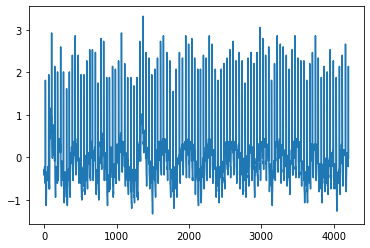

In [17]:
plt.plot(y3)
plt.show()

In [18]:
sampling_rt=len(y)/60

In [19]:
sampling_rt

70.11666666666666

In [20]:
ecg = pd.Series(i for i in y3)

In [21]:
ecg

0      -0.412033
1      -0.280964
2      -0.412033
3      -0.412034
4      -0.346500
          ...   
4202   -0.018819
4203    1.947262
4204    2.143871
4205    0.505469
4206   -0.018818
Length: 4207, dtype: float64

In [22]:
ecg_signals, info  = nk.ecg_process(ecg, sampling_rate=71)

In [23]:
info

{'ECG_R_Peaks': array([  63,  103,  146,  185,  228,  267,  310,  348,  390,  428,  471,
         509,  551,  588,  630,  667,  708,  745,  785,  822,  864,  902,
         945,  985, 1028, 1068, 1113, 1153, 1198, 1239, 1282, 1321, 1363,
        1407, 1449, 1489, 1529, 1566, 1608, 1648, 1692, 1737, 1783, 1824,
        1869, 1911, 1956, 1997, 2040, 2080, 2122, 2160, 2201, 2240, 2282,
        2322, 2365, 2404, 2447, 2485, 2528, 2567, 2611, 2652, 2696, 2736,
        2779, 2817, 2860, 2899, 2942, 2980, 3022, 3061, 3103, 3142, 3183,
        3221, 3263, 3302, 3343, 3386, 3425, 3468, 3507, 3549, 3588, 3630,
        3667, 3709, 3747, 3789, 3828, 3871, 3910, 3954, 3994, 4038, 4078,
        4120, 4164]),
 'sampling_rate': 71}

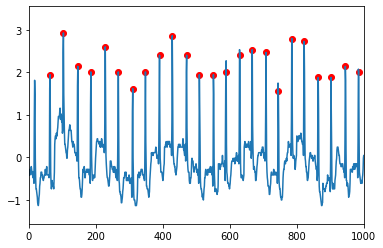

In [24]:
plt.plot(ecg)
plt.scatter(info['ECG_R_Peaks'],ecg [info['ECG_R_Peaks']], color="red")
plt.gca().set_xlim(0, 1000)
plt.show()

In [25]:
rr_ecg = np.diff(info['ECG_R_Peaks'])
corr_rr_ecg = rr_ecg*10

# Time domain analysis of ECG

In [26]:
timedomain(corr_rr_ecg)

{'Mean RR (ms)': 410.1,
 'STD RR/SDNN (ms)': 22.649282549343592,
 "Mean HR (Kubios' style) (beats/min)": 146.3057790782736,
 'Mean HR (beats/min)': 146.75512854908607,
 'STD HR (beats/min)': 8.148837600945274,
 'Min HR (beats/min)': 130.43478260869566,
 'Max HR (beats/min)': 162.16216216216216,
 'RMSSD (ms)': 37.416573867739416,
 'NNxx': 0,
 'pNNxx (%)': 0.0}

# Interpolated ECG Signal

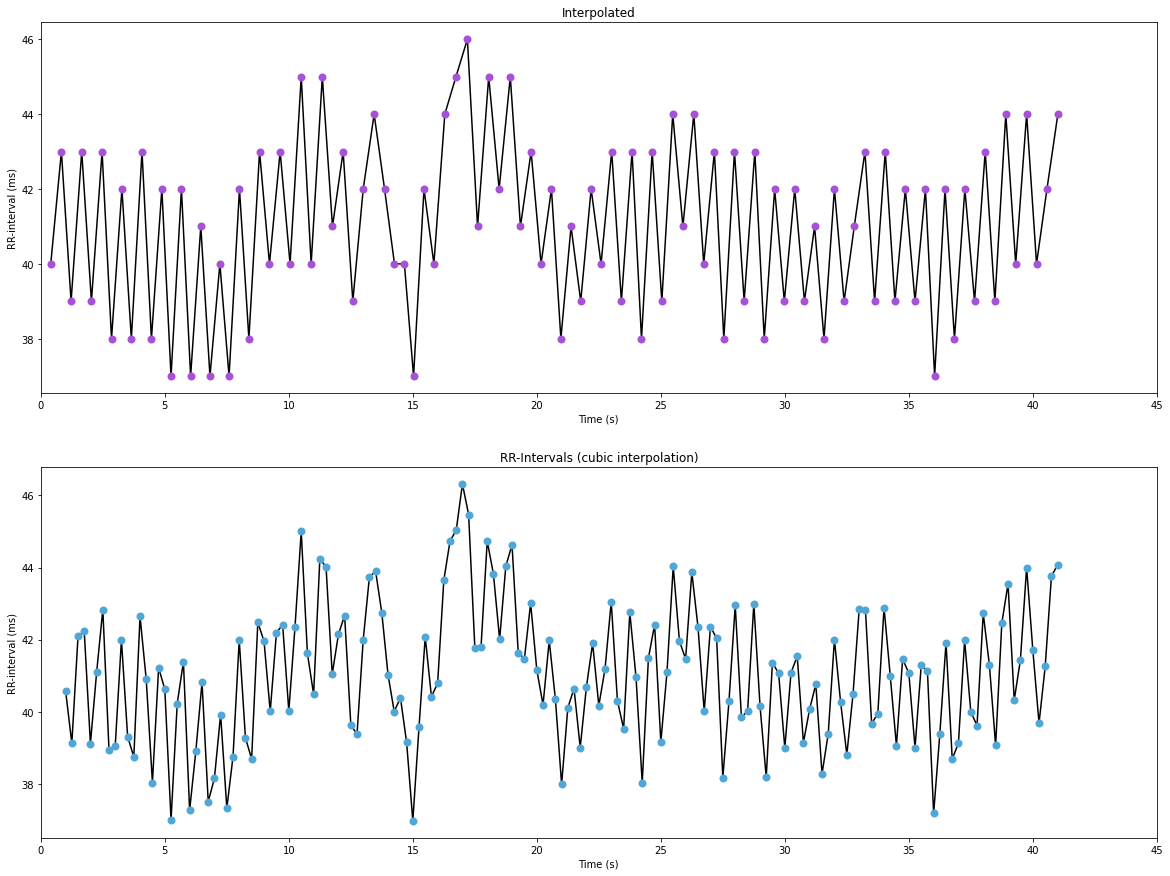

In [27]:
x_ecg = np.cumsum(rr_ecg)/ 100.0
f_ecg = interp1d(x_ecg, rr_ecg, kind='cubic',fill_value="extrapolate")

# sample rate for interpolation
fs = 4.0
steps = 1 / fs

# now we can sample from interpolation function
xx_ecg = np.arange(1, np.max(x_ecg), steps)
xx_ecg.shape

rr_interpolated_ecg = f_ecg(xx_ecg)

plt.figure(figsize=(20, 15))

plt.subplot(211)
plt.title("RR intervals")
plt.plot(x_ecg, rr_ecg, color="k", markerfacecolor="#A651D8", markeredgewidth=0, marker="o", markersize=8)
plt.xlabel("Time (s)")
plt.ylabel("RR-interval (ms)")
plt.title("Interpolated")
plt.gca().set_xlim(0, 45)

plt.subplot(212)
plt.title("RR-Intervals (cubic interpolation)")
plt.plot(xx_ecg, rr_interpolated_ecg, color="k", markerfacecolor="#51A6D8", markeredgewidth=0, marker="o", markersize=8)
plt.gca().set_xlim(0, 45)
plt.xlabel("Time (s)")
plt.ylabel("RR-interval (ms)")
plt.show()

# Frequenzy domain analysis of ECG signal

In [28]:
print("Frequency domain metrics:")
results_ecg, fxx_ecg, pxx_ecg = frequency_domain(rr_interpolated_ecg)

for k_e, v_e in results_ecg.items():
    print("- %s: %.2f" % (k_e, v_e))

Frequency domain metrics:
- Power VLF (ms2): 0.17
- Power LF (ms2): 0.87
- Power HF (ms2): 0.67
- Power Total (ms2): 1.72
- LF/HF: 1.30
- Peak VLF (Hz): 0.02
- Peak LF (Hz): 0.12
- Peak HF (Hz): 0.32
- Fraction LF (nu): 56.52
- Fraction HF (nu): 43.48


C:\Users\fffmm\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 256 is greater than input length  = 161, using nperseg = 161
  warnings.warn('nperseg = {0:d} is greater than input length '


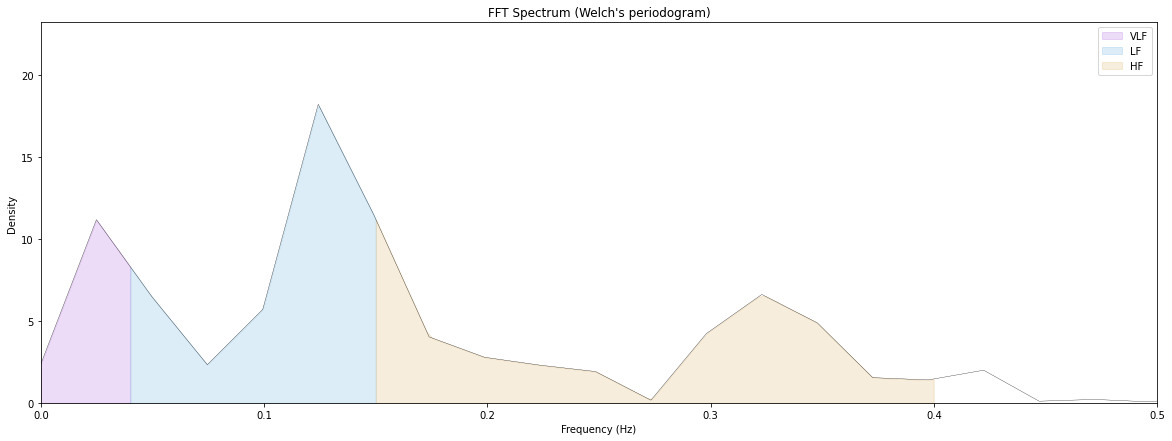

In [29]:
plt.figure(figsize=(20, 7))
plt.plot(fxx_ecg, pxx_ecg, color="k", linewidth=0.3)
plt.title("FFT Spectrum (Welch's periodogram)")

# create interpolation function for plotting frequency bands
psd_f = interp1d(fxx_ecg, pxx_ecg)

# setup frequency bands for plotting
x_vlf = np.linspace(0, 0.04, 100)
x_lf = np.linspace(0.04, 0.15, 100)
x_hf = np.linspace(0.15, 0.4, 100)

plt.gca().fill_between(x_vlf, psd_f(x_vlf), alpha=0.2, color="#A651D8", label="VLF")
plt.gca().fill_between(x_lf, psd_f(x_lf), alpha=0.2, color="#51A6D8", label="LF")
plt.gca().fill_between(x_hf, psd_f(x_hf), alpha=0.2, color="#D8A651", label="HF")

plt.gca().set_xlim(0, 0.5)
plt.gca().set_ylim(0)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Density")
plt.legend()
plt.show()